In [1]:
import matplotlib.pyplot as plt
import numpy as np
import heapq
import logging
import sys
import time
import math
from capper import Reads
import capper

In [2]:
start_time = time.time()
# Parse the 1kg reads
reads_1kg_small = Reads("minimizers_1kg_single/minimizers_correct",
              "minimizers_1kg_single/minimizers_incorrect",
              max_correct_reads=10000)
print("Got ", len(reads_1kg_small.reads), " in ", time.time() - start_time, " seconds")

Got  40181  in  51.459314823150635  seconds


In [3]:
start_time = time.time()
# Parse the hgsvc reads
reads_hgsvc_small = Reads("minimizers_hgsvc_single/minimizers_correct",
              "minimizers_hgsvc_single/minimizers_incorrect",
              max_correct_reads=10000)
print("Got ", len(reads_hgsvc_small.reads), " in ", time.time() - start_time, " seconds")

Got  66684  in  94.51273536682129  seconds


In [4]:
def current_cap(r):
    """
    if r.xian_cap != p_inf:
        print("what", r.capped_map_q, int(min(r.uncapped_map_q, r.xian_cap, r.vg_computed_cap, 60)), r.uncapped_map_q, r.xian_cap, r.vg_computed_cap)
    if r.capped_map_q != int(min(r.uncapped_map_q, r.xian_cap, r.vg_computed_cap, 60)):
        print("wait", r.capped_map_q, int(min(r.uncapped_map_q, r.xian_cap, r.vg_computed_cap, 60)),
                r.uncapped_map_q, r.xian_cap, r.vg_computed_cap)
    """
    return r.capped_map_q  # round(min(r.uncapped_map_q, f(r.xian_cap), r.vg_computed_cap, 60))

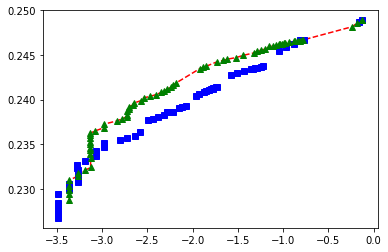

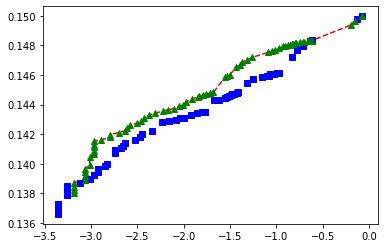

 Took  1.5201048851013184  seconds


In [9]:
## Make the small plots

def calc_map_q(r):
    assert(len(r.alignment_scores) > 0)
    
    if len(r.alignment_scores) == 1:
        if r.alignment_scores[0] == 0.0: # Case is unaligned
            return 0.0
        return 10000 # Case is the only alignment
    
    x = max(r.alignment_scores)
    y = r.alignment_scores[:-1]
    s = 1.4 #43429
    #secondary_count = len(r.alignment_scores)-1 if len(r.alignment_scores) > 1 else 1
    #unexplored_minimizers = r.avg_unexplored_minimizers()
    #if unexplored_minimizers < 100:
    #    unexplored_minimizers = 0
    #unexplored_multiplicity = unexplored_minimizers / secondary_count #math.log10(r.avg_unexplored_minimizers() + 1)
    
    # Add together the alignment scores, from smallest to largest
    p = math.exp(x * s)
    for y in r.alignment_scores[:-1]:
        p += math.exp(y *s) #* (1.0 + unexplored_multiplicity)
    
    z = math.exp(x * s) / p
    map_q = (-10 * math.log10(1 - z)) if z < 1.0 else 100000
    
    return map_q # r.uncapped_map_q

def proposed_cap(r):    
    escape_bonus = 1.0 if r.uncapped_map_q < 1000 else 2.0
    
    #if r.alignment_score >= 140:
    #    escape_bonus += 10
    #escape_bonus = 0.0 if total_unexplored_minimizers(r) >= 10 else 20

    #escape_bonus = 1.0
    #if r.alignment_score >= 140 and (r.uncapped_map_q >= 1000 or r.avg_unexplored_minimizers() <= 100):
    #    escape_bonus = 2.0

    #assert r.xian_cap == capper.p_inf
    
    return round(min(r.faster_cap_precomputed * escape_bonus, calc_map_q(r), 70))

def proposed_cap_2(r):    
    escape_bonus = 1.0 if r.uncapped_map_q < 1000 else 2.0
    
    #if r.alignment_score >= 140:
    #    escape_bonus += 10
    #escape_bonus = 0.0 if total_unexplored_minimizers(r) >= 10 else 20

    #escape_bonus = 1.0
    #if r.alignment_score >= 140 and (r.uncapped_map_q >= 1000 or r.avg_unexplored_minimizers() <= 100):
    #    escape_bonus = 2.0

    #assert r.xian_cap == capper.p_inf
    
    return round(min(r.faster_cap_precomputed * escape_bonus, r.xian_cap, calc_map_q(r), 70))

def make_rocs(reads):
    # Make ROC curves
    roc_unmodified = reads.get_roc(map_q_fn=proposed_cap)
    #print("Roc unmodified", roc_unmodified)
    roc_adam_modified = reads.get_roc(map_q_fn=current_cap)
    #print("Roc adam modified ", roc_adam_modified)
    start_time = time.time()
    roc_new_sum_modified = reads.get_roc(map_q_fn=proposed_cap_2)
    #print("Roc mode modified (time:{}) ".format(time.time()-start_time), roc_new_sum_modified)
    #Reads.plot_rocs([roc_unmodified, roc_adam_modified, roc_new_sum_modified])
    
    Reads.plot_rocs([roc_unmodified, roc_adam_modified, roc_new_sum_modified ])

start_time = time.time()
make_rocs(reads_1kg_small)
make_rocs(reads_hgsvc_small)
print(" Took ", time.time() - start_time, " seconds")

In [11]:
start_time = time.time()
# Parse the hgsvc reads
reads_hgsvc = Reads("minimizers_hgsvc_single/minimizers_correct",
              "minimizers_hgsvc_single/minimizers_incorrect",
              max_correct_reads=100000000)
print("Got ", len(reads_hgsvc.reads), " in ", time.time() - start_time, " seconds")

Got  2000000  in  56368.00056505203  seconds


In [ ]:
start_time = time.time()
# Parse the 1kg reads
reads_1kg = Reads("minimizers_1kg_single/minimizers_correct",
              "minimizers_1kg_single/minimizers_incorrect",
              max_correct_reads=100000000)
print("Got ", len(reads_1kg.reads), " in ", time.time() - start_time, " seconds")

In [ ]:
## Make the big plots

start_time = time.time()
make_rocs(reads_1kg)
make_rocs(reads_hgsvc)
print(" Took ", time.time() - start_time, " seconds")

In [ ]:
#  Print some of the funky reads
def print_stages(reads, map_q):
    stages = {}
    total_wrong = 0
    for i, read in enumerate(reads.reads):
        if not read.correct and proposed_cap(read) >= map_q: # and read.stage == "cluster":
            #print("Read {} {}".format(i, read))
            if read.stage not in stages:
                stages[read.stage] = 0
            stages[read.stage] += 1
            total_wrong += 1
    print("Total wrong", total_wrong, "Wrong stages single end:", stages)
    
print("hgsvc")
print_stages(reads_hgsvc_small, 60)

print("1kg")
print_stages(reads_1kg_small, 60)